In [11]:
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# May be necessary to add the base path of LittleStarr directory to sys.path
BASE_PATH = "/home/claysmyth/code/"

In [13]:
BASE_PATH

'/home/claysmyth/code/'

In [74]:
import sys
sys.path.append("/home/claysmyth/code/")
import pandas as pd
import numpy as np
import glob
from functools import partial
from LittleStarr.visualization_functions import rcs_visualization as rv
import polars as pl
from multipledispatch import dispatch
import scipy.signal as signal
import matplotlib.pyplot as plt
import scipy.stats as stats
from LittleStarr.data_processing import data_transforms as dt
# from LittleStarr.analytics import utils as au
# Throws error: from LittleStarr.analytics import signal_processing as sp
import utils
import csv
import os
import datetime

# Notebook Parameters

In [28]:
# Parameters
parent_directories = ['/media/longterm_hdd/Clay/Sleep_10day/RCS02L/Overnight',
                     '/media/longterm_hdd/Clay/Sleep_10day/RCS02R/Overnight',
                     '/media/longterm_hdd/Clay/Sleep_10day/RCS03L/Overnight',
                     '/media/longterm_hdd/Clay/Sleep_10day/RCS03R/Overnight',
                     '/media/longterm_hdd/Clay/Sleep_10day/RCS16L/Overnight',
                     '/media/longterm_hdd/Clay/Sleep_10day/RCS16R/Overnight']
file_paths_csv = '/media/longterm_hdd/Clay/DREEM_data/filepaths_02_03_16_matlab_copy.csv'
desired_columns = ['DerivedTime', 'TD_key0', 'TD_key2', 'TD_key3', 'SleepStage']

In [18]:
def get_PSD_as_array(data, sample_rate, epoch_length, window_length, overlap, column_format=False):
    """
    Takes time series data of arbitrary complexity, and reshapes the time-series portion into a (n x epoch_length) array, then applies the welch method of PSD estimation on each row in (n).
    Assumes the last 2 dimensions are (num channels x num time samples). If last 2 dimensions are (num time samples x num channels), then column_format should be toggled to True.
    :param data: Raw time series data, where last two dimensions should be (num channels x num time samples) or (num samples x num time channels).
    :param sample_rate: sample rate of time series samples [Hz]
    :param epoch_length: number of samples in the resulting row, on which PSD is calculated [int]
    :param window_length: number of samples for welch window [int]
    :param overlap: number of samples to overlap welch windows [int]
    :param column_format: Set to true if last 2 dimensions of input data is (num time samples x num channels)
    :return:
        f: output array f of the signal.welch
        Pxx_den: an (n x f) array denoting the resulting power spectral estimation for each epoch.
    """
    if column_format:
        data = np.transpose(data, np.shape(data)[:-2] + (-1, -2))

    # Ignore tail end of data that does not fit into welch epoch
    num_chunks = (np.shape(data)[-1] - epoch_length) // epoch_length

    # Chunk the time series portion of the data into an (n x epoch_length) array.
    # The last dimension will be a continuous section of data of epoch length, and second to last will be contiguous epochs.
    data_epoch_blocked = np.reshape(data[...,:num_chunks*epoch_length], (np.shape(data)[:-1]) + (num_chunks, epoch_length))

    # Run PSD calculation on each epoch of data (the last dimension)
    f, Pxx_den = signal.welch(data_epoch_blocked, fs=sample_rate, nperseg=window_length, noverlap=overlap)

    return f, Pxx_den

In [19]:
def get_PSD_dict(data_dict, cols, value_type, **kwargs):
    """
    Wrapper function for get_PSD_as_array(...). Processes data values in data_dict into PSD_arrays
    :param data_dict: dictionary pairs of key - dataframe [either dask, pandas, or polars]
    :param cols: [list of strings] cols to extract from dataframe values. Are ultimately transformed into numpy arrays
    :param value_type: [string] indicates what type of dataframe are stored as values in data_dict
    :param **kwargs: parameter values for get_PSD_as_array(...)
    :return:
        f: output array f of the signal.welch
        psd_dictionary: keys of data_dict pairs with Pxx_den, as outputted from get_PSD_as_array(...)
    """
    if value_type == 'polars':
        psd_dict = {key: get_PSD_as_array(data=value.select(cols).fill_null(0).to_numpy().T, **kwargs)
                    for key, value in data_dict.items()}
    elif value_type == 'dask':
        psd_dict = {key: get_PSD_as_array(data=value[cols].fillna(0).compute().values.T, **kwargs)
                    for key, value in data_dict.items()}
    elif value_type == 'pandas':
        psd_dict = {key: get_PSD_as_array(data=value[cols].fillna(0).values.T, **kwargs)
                    for key, value in data_dict.items()}
    else:
        print('Not a recognized value_type. Allowed types are dask, pandas, or polars')
        return
    keys = list(psd_dict.keys())
    f = psd_dict[keys[0]][0]
    return f, {key: value[1] for key, value in psd_dict.items()}


In [20]:
def process_PSDs_for_channel(psd_dict, channel):
    """
    Processes PSD arrays for plotting. Processes PSD arrays by taking the log of the psd array for each channel, and calculating the average and sem of the log(data) for each channel
    :param psd_dict: key-value pairing, where each value is an (num channels x n x psd length) array of power spectral density estimates
    :param channel: [tuple, e.g. (1,2) or (1) or just 1] index on which to process the psd array
    :return: average [1 x psd length] and standard error measure [1 x psd length] of the input psd array
    """
    ave = {}
    sem = {}
    for key, arr in psd_dict.items():
        arr_pruned = arr[channel][np.where(~(arr[channel] == 0).any(axis=-1)),:].squeeze()
        arr_log = np.log10(arr_pruned)
        ave[key] = np.average(arr_log, axis=-2)
        sem[key] = stats.sem(arr_log, axis=-2)
    return ave, sem


# Device Summary Statistics (all 10 nights)

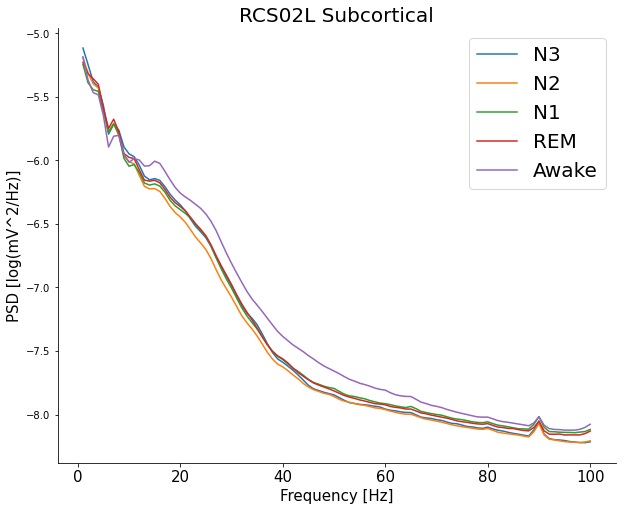

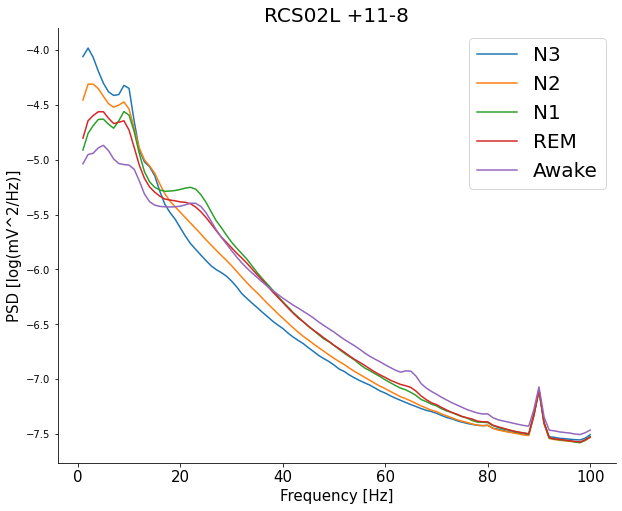

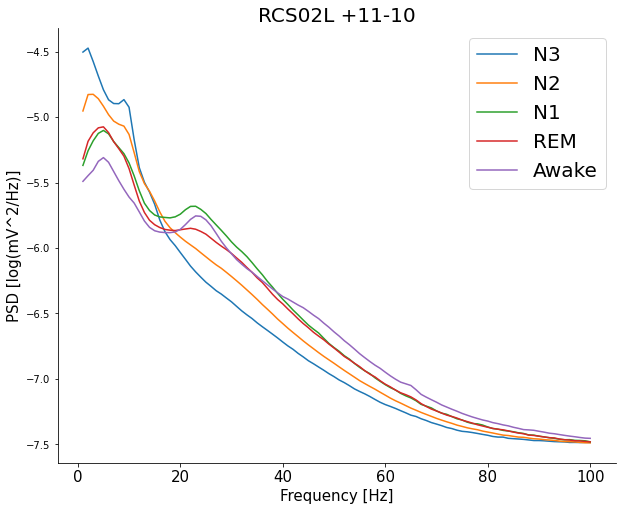

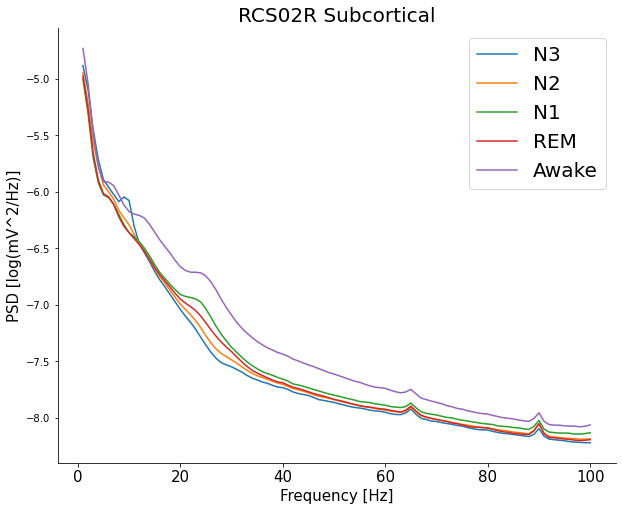

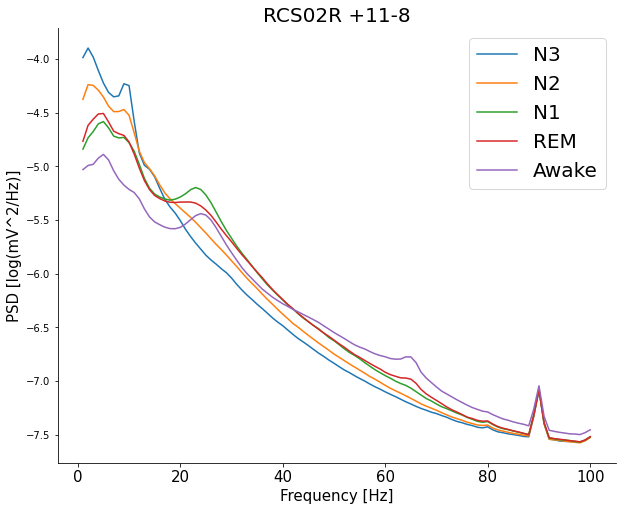

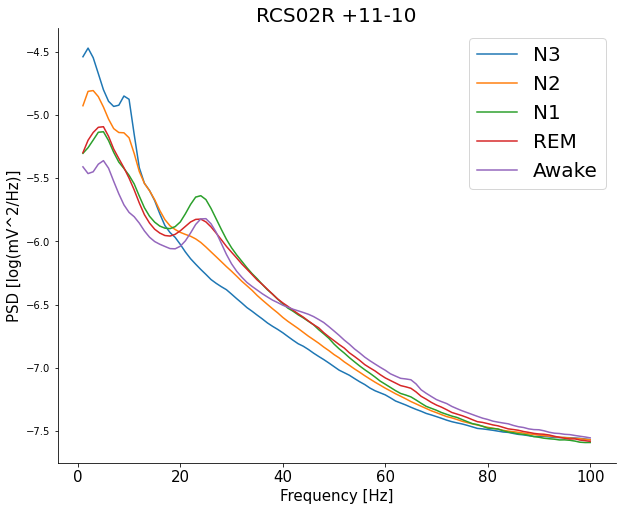

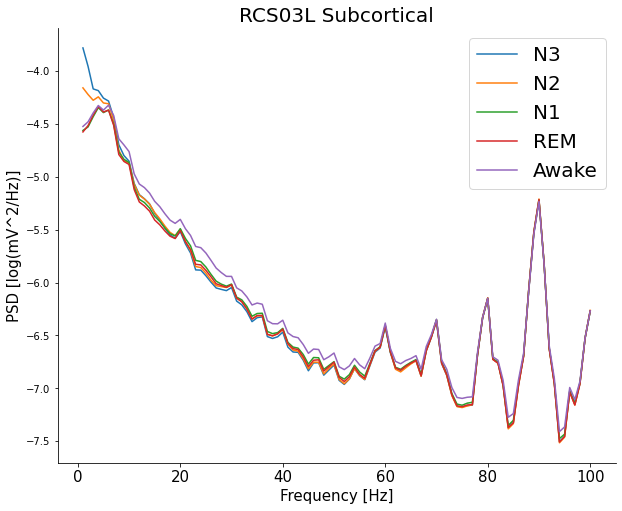

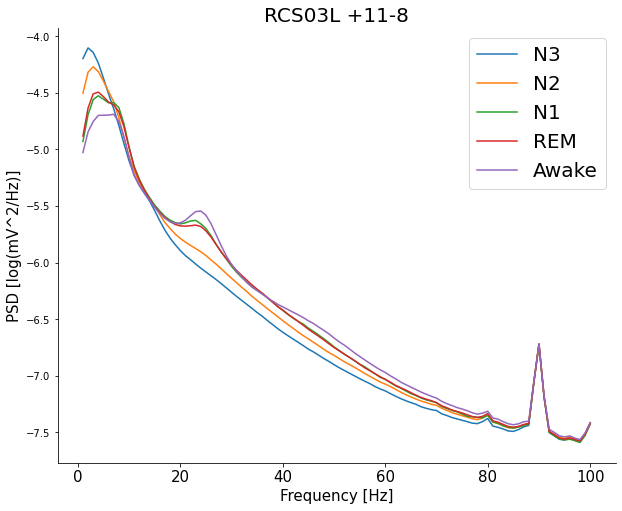

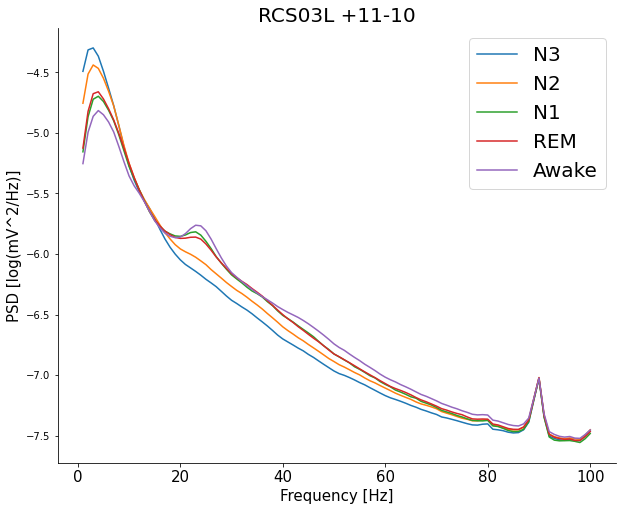

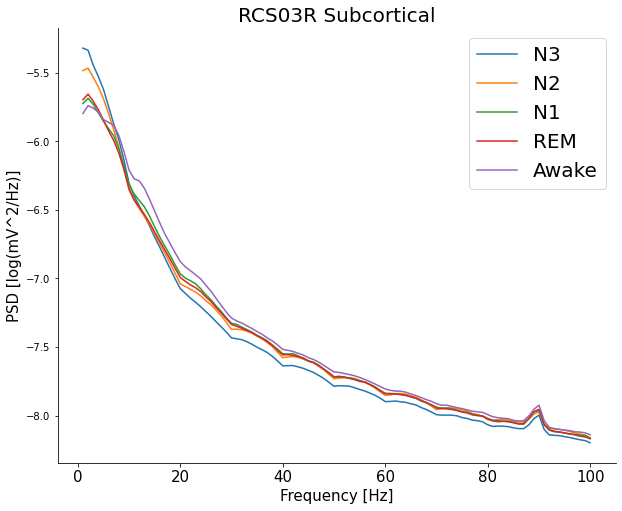

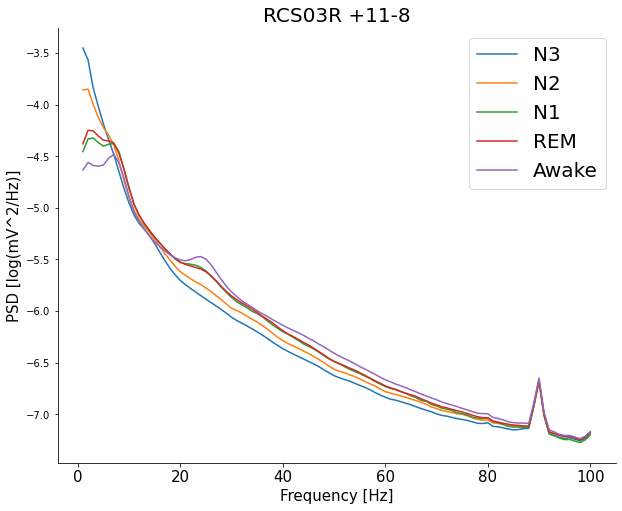

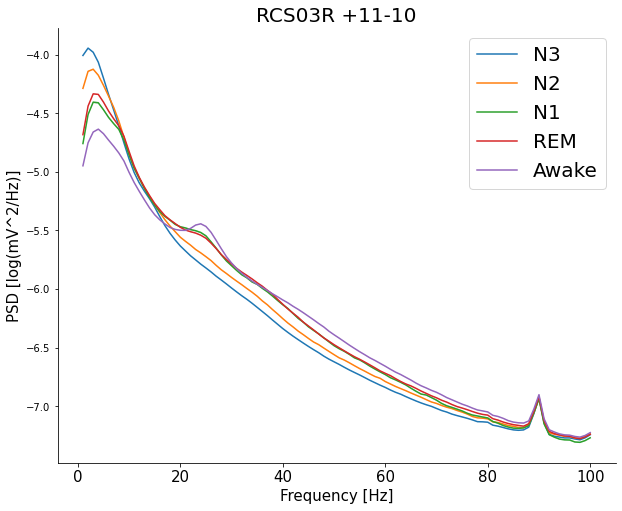

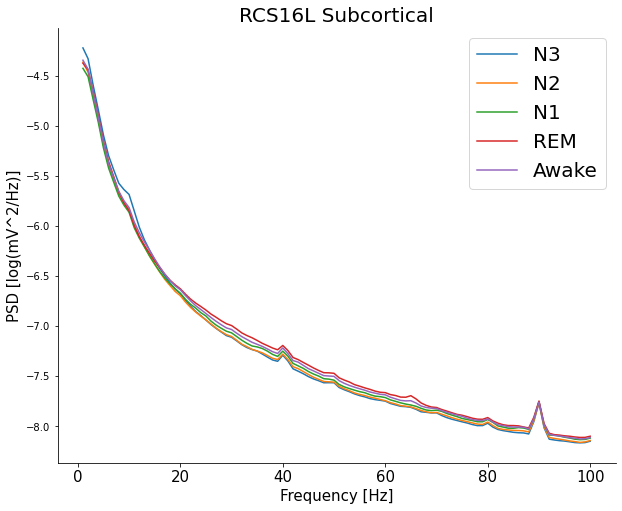

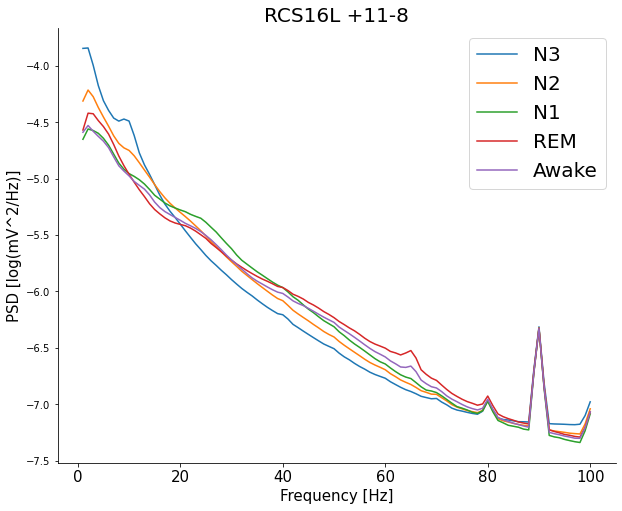

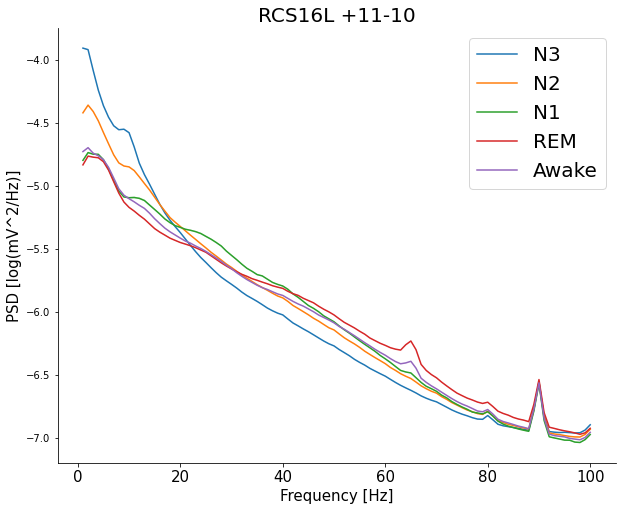

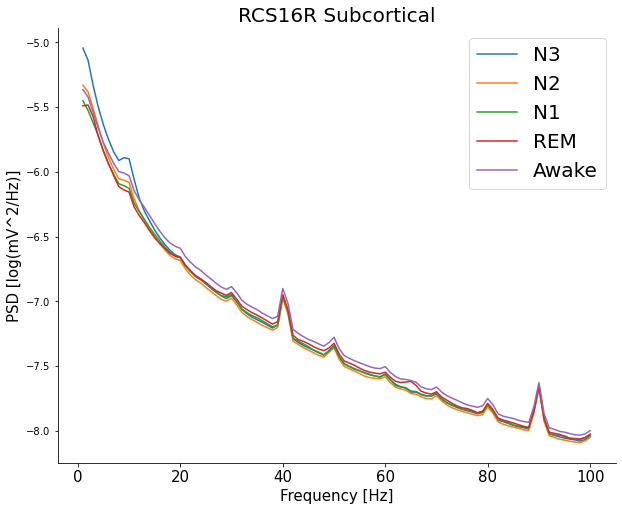

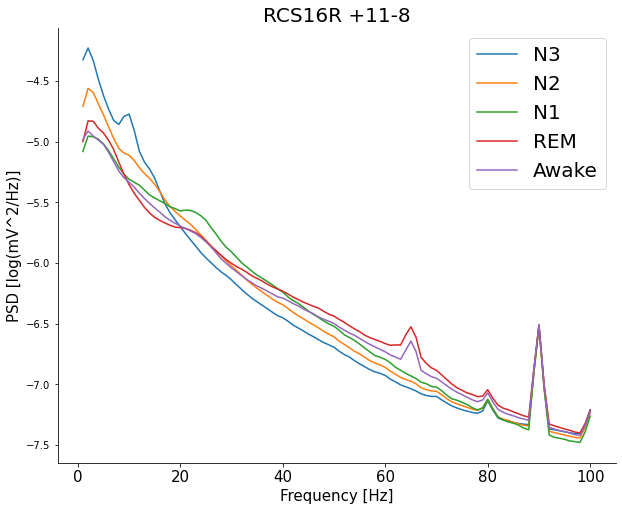

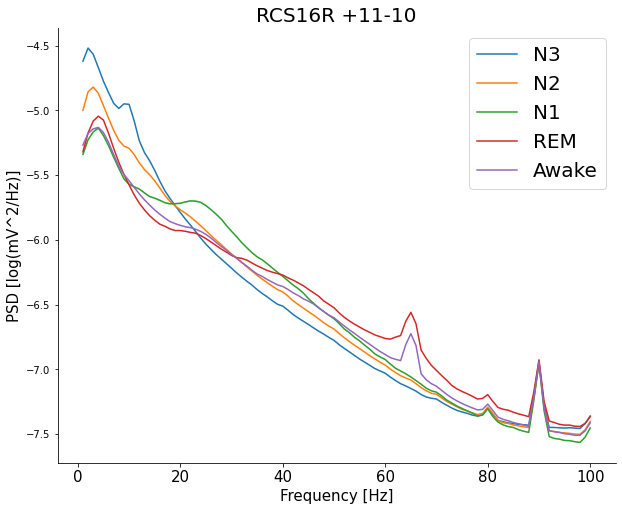

In [27]:
psd_params = {'sample_rate':500, 'epoch_length':1000, 'window_length':500, 'overlap':250, 'column_format':False}
labels = {2:'N3', 3:'N2', 4:'N1', 5:'REM', 6:'Awake'}

for dir in parent_directories:
    raw_data_files = glob.glob(dir + '/*.parquet')
    rcs_pl = pl.read_parquet(
        dir+'/*.parquet',
        columns = desired_columns
    )
    device = dir.split('/')[-2]

    pl_data_dict = dt.get_sleep_stage_dict(rcs_pl, desired_columns)
    f, psd_dict = get_PSD_dict(pl_data_dict, ['TD_key0', 'TD_key2', 'TD_key3'], 'polars', **psd_params)

    td_key0_ave, td_key0_sem = au.process_PSDs_for_channel(psd_dict, 0)
    td_key2_ave, td_key2_sem = au.process_PSDs_for_channel(psd_dict, 1)
    td_key3_ave, td_key3_sem = au.process_PSDs_for_channel(psd_dict, 2)

    rv.plot_PSD(td_key0_ave, labels, device + ' Subcortical', f, plot_SEM=True, SEM=td_key0_sem)
    rv.plot_PSD(td_key2_ave, labels, device + ' +11-8', f, plot_SEM=True, SEM=td_key2_sem)
    rv.plot_PSD(td_key3_ave, labels, device + ' +11-10', f, plot_SEM=True, SEM=td_key3_sem)

# Single Session Metadata and Spectrograms

In [ ]:
plot_spec = partial(rv.plot_spec_hypno_overlay, sample_rate=500, window_length=1000, overlap=500, freq_range=np.s_[1:201], max=10**-2)

for f in raw_data_files:
    df_tmp = pd.read_parquet(f)
    plot_spec(df_tmp, 'TD_key3', title=f)

In [ ]:
plot_spec = partial(rv.plot_spec_hypno_overlay, sample_rate=500, window_length=1000, overlap=500, freq_range=np.s_[1:201], max=10**-2)

for overnight in raw_data_files:
    df_tmp = pd.read_parquet(overnight)
    print('Overnight Session: ' + overnight)
    plot_spec(df_tmp, 'TD_key0', title=f'{overnight.split("/")[-3]} : {overnight.split("/")[-1]} : Subcortical')
    print('Percent Disconnects: ' + utils.get_percent_Nans(df_tmp, 'TD_key0'))
    plot_spec(df_tmp, 'TD_key2', title=f'{overnight.split("/")[-3]} : {overnight.split("/")[-1]} : +11-8')
    print('Percent Disconnects: ' + utils.get_proportion_Nans(df_tmp, 'TD_key2'))
    plot_spec(df_tmp, 'TD_Key3', title=f'{overnight.split("/")[-3]} : {overnight.split("/")[-1]} : +11-10')
    print('Percent Disconnects: ' + utils.get_proportion_Nans(df_tmp, 'TD_key3'))
    print("____________________________________________________________________________________________________________________\n")

# Filepath and Unittest Checks

In [38]:
file_paths_df = pd.read_csv(file_paths_csv)

In [32]:
file_paths.head()

,Var1,H5,Txt,DateTime,RCS#,Side,Session#,SessionType(s),TimeStarted,TimeEnded,Notes,Data_Server_FilePath,SleepStage_Labeled_RCS_Parquet
0,0,/media/longterm_hdd/Clay/DREEM_data/RCS02/Fuan...,/media/longterm_hdd/Clay/DREEM_data/RCS02/Fuan...,2022-05-06,RCS02,Left,Session1651816921878,Overnight,05-05-2022 23:02:01,05-06-2022 03:16:51,NaN,'/media/dropbox_hdd/Starr Lab Dropbox/RC+S Pat...,/media/longterm_hdd/Clay/Sleep_10day/RCS02L/Ov...
1,1,/media/longterm_hdd/Clay/DREEM_data/RCS02/Fuan...,/media/longterm_hdd/Clay/DREEM_data/RCS02/Fuan...,2022-05-06,RCS02,Right,Session1651816907886,Overnight,05-05-2022 23:01:47,05-06-2022 02:20:58,NaN,'/media/dropbox_hdd/Starr Lab Dropbox/RC+S Pat...,/media/longterm_hdd/Clay/Sleep_10day/RCS02R/Ov...
2,2,/media/longterm_hdd/Clay/DREEM_data/RCS02/Fuan...,/media/longterm_hdd/Clay/DREEM_data/RCS02/Fuan...,2022-04-28,RCS02,Left,Session1651124299038,Overnight,04-27-2022 22:38:19,04-28-2022 01:40:46,NaN,'/media/dropbox_hdd/Starr Lab Dropbox/RC+S Pat...,/media/longterm_hdd/Clay/Sleep_10day/RCS02L/Ov...
3,3,/media/longterm_hdd/Clay/DREEM_data/RCS02/Fuan...,/media/longterm_hdd/Clay/DREEM_data/RCS02/Fuan...,2022-04-28,RCS02,Right,Session1651124289341,Overnight,04-27-2022 22:38:09,04-28-2022 02:33:48,NaN,'/media/dropbox_hdd/Starr Lab Dropbox/RC+S Pat...,/media/longterm_hdd/Clay/Sleep_10day/RCS02R/Ov...
4,4,/media/longterm_hdd/Clay/DREEM_data/RCS02/Fuan...,/media/longterm_hdd/Clay/DREEM_data/RCS02/Fuan...,2022-04-26,RCS02,Left,Session1650952172805,Overnight,04-25-2022 22:49:32,04-26-2022 06:19:08,NaN,'/media/dropbox_hdd/Starr Lab Dropbox/RC+S Pat...,/media/longterm_hdd/Clay/Sleep_10day/RCS02L/Ov...


In [85]:
def get_dreem_report_csv_as_dict(report_base_path, date):
    date = datetime.datetime.strptime(date, '%Y-%m-%d')
    report_file = [report for report in os.listdir(report_base_path) if date.strftime("%d-%b-%Y") in report if not report.startswith('.')]
    if not report_file:
        return "", None
    else:
        report_file_path = report_base_path + report_file[0]
        report_df = pd.read_csv(report_file_path)
        report_dict = dict(zip(report_df.iloc[:,0], report_df.iloc[:,1]))
        return report_file_path, report_dict

In [86]:
for overnight in raw_data_files:
    df_ind = file_paths_df.index[file_paths_df['SleepStage_Labeled_RCS_Parquet'] == overnight]
    curr_row = file_paths_df.iloc[df_ind,:]
    dreem_reports_base_path = '/'.join(str.split(curr_row['H5'].values[0], '/')[:-2]) + '/Reports/'
    report_file, report_dict = get_dreem_report_csv_as_dict(dreem_reports_base_path, curr_row['DateTime'].values[0])
    print(f"""Parquet File: {overnight}
          Dreem H5 file: {curr_row['H5'].values[0]}
          Dreem Txt file: {curr_row['Txt'].values[0]}
          RC+S Data Dir: {curr_row['Data_Server_FilePath'].values[0]}
          Dreem Report file: {report_file}
          """)



Parquet File: /media/longterm_hdd/Clay/Sleep_10day/RCS16R/Overnight/Session1652682767528_16-May-2022.parquet
          Dreem H5 file: /media/longterm_hdd/Clay/DREEM_data/RCS16/Mor-05@dreem.com/H5/Mor-05@dreem.com---16-May-2022 07-02-08.h5
          Dreem Txt file: /media/longterm_hdd/Clay/DREEM_data/RCS16/Mor-05@dreem.com/SleepData/Mor-05@dreem.com---16-May-2022 07-02-08.txt
          RC+S Data Dir: '/media/dropbox_hdd/Starr Lab Dropbox/RC+S Patient Un-Synced Data/RCS16 Un-Synced Data/SummitData/SummitContinuousBilateralStreaming/RCS16R/Session1652682767528/DeviceNPC700487H'
          Dreem Report file: /media/longterm_hdd/Clay/DREEM_data/RCS16/Mor-05@dreem.com/Reports/Mor-05@dreem.com---16-May-2022 07-02-08.csv
          
Parquet File: /media/longterm_hdd/Clay/Sleep_10day/RCS16R/Overnight/Session1651994225088_08-May-2022.parquet
          Dreem H5 file: /media/longterm_hdd/Clay/DREEM_data/RCS16/Mor-05@dreem.com/H5/Mor-05@dreem.com---08-May-2022 07-05-21.h5
          Dreem Txt file: /m

In [87]:
# TODO: Create function that parses Session directory and returns device settings
    # Call matlab(?) Shouldn't be too hard